import modules

In [32]:
import sys

sys.path.insert(0, "../abc")
import torch as t
import numpy as np
import matplotlib.pyplot as plt
from model import init_grids, model
from vis_utils import visualize_batch, visualize_sequence
from utils import chop_and_shuffle_data, heaviside
from likelihoods import spread_likelihood
from math import factorial

# Combining ABC and Gradient Descent to learn $\beta$ without access to the likelihood

In this experiment, we try to learn $\beta$ without having access to the likelihood function. The reason for this, is that in more complex models the likelihood function can be intractable.

## 1. Making the PCA model differentiable

So far, we have defined the PCA in a non-differentiable form. For the first experiment, this was fine as we did not have to differentiate through the model itself, but through the likelihood function. In the second experiment, it was also fine as we did not use any gradients. 

For the following experiment, however, it is necessary to be able to differentiate through the model w.r.t. $\beta$. The problem we face, is that the model is discrete. At every time step, cells need to do discrete transitions (e.g. 0 -> 1). Fully discrete functions (i.e. a step/heaviside function) are not differentiable. 

To solve the issue, we need to find a differentiable approximation of the model

### approximating the heaviside/step function

We use a differentiable approximation of the heaviside function. The approximation has a hyperparameter $k$ that let's us define how well the function approximates a discrete step. Here, we have to consider a trade-off between the quality of the approximation and the usefulness of the gradient. The higher $k$, the lower the gradients will be.

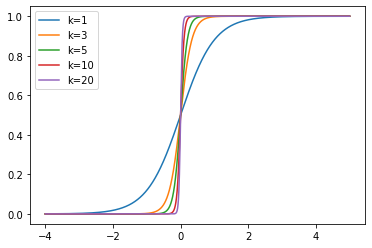

In [6]:
test_vals = t.linspace(-4, 5, 10_000)
constants = [1,3,5,10,20]

for k in constants:
    y = heaviside(test_vals, k=k)
    plt.plot(test_vals, y, label=f"k={k}")

plt.legend()
plt.show()

### define the model approximation

In [8]:
def model_approx(grids: t.Tensor, beta: t.Tensor) -> t.Tensor:
    # produces a mask that is 1 for all healthy cells, 0 for the infected cells
    healthy_mask = 1 - grids
    # calculate the likelihood of spread 
    likelihoods = spread_likelihood(grids, beta)
    # compare each likelihood to a random value ~ U(0,1) to get the residual values
    residuals = likelihoods - t.rand(*grids.shape)
    # apply the heaviside to the residuals,
    #   if the residual is positive, the cell should be infected ( < spread_likelihood)
    #   if the residual is negative, the cell should stay healthy ( > spread_likelihood)
    #   if the cell was already infected, no update should be applied 
    update_mask = heaviside(residuals, k=20) * healthy_mask
    # apply the update to the current state
    return grids + update_mask

We can visualize a comparison between this approximate model and the original model:

[Text(0.5, 1.0, 'generated with orig. model')]

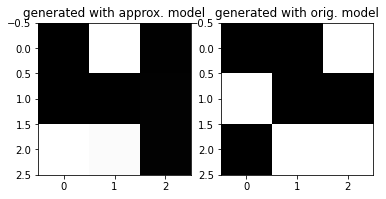

In [14]:
x_t = t.zeros((1, 3, 3))
x_t[0, 1, 1] = 1

fig, axs = plt.subplots(1,2)
test = model_approx(x_t, t.tensor(0.5))
axs[0].imshow(test[0], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
axs[0].set(title="generated with approx. model")
# %%
test2 = model(x_t, t.tensor(0.5))
axs[1].imshow(test2[0], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
axs[1].set(title="generated with orig. model")

## 2. Summary statistics and distance function

We can use the same summary statistics and distance function as in experiment 2:

In [16]:
def S1(X: t.Tensor, Y: t.Tensor) -> t.Tensor:
    return t.sum((1 - X) * Y, axis=(-1, -2))


def calc_distance(X, Y_sim: t.Tensor, Y_obs: t.Tensor) -> float:
    # get statistics of the simulated set
    s_sim = S1(X, Y_sim)
    # get statistics of the observed set
    s_obs = S1(X, Y_obs)
    # calculate the mean ratio
    return (1 - t.mean(s_sim / (s_obs + 1))) ** 2

We can calculate the distance for an example:

In [23]:
x_t = t.zeros((1, 3, 3))
x_t[0, 1, 1] = 1

x_tt1 = model(x_t, t.tensor(0.6))
x_tt2 = model_approx(x_t, t.tensor(0.2))

calc_distance(x_t, x_tt1, x_tt2)

tensor(1.0295, dtype=torch.float64)

## 3. Differentiating through the distance w.r.t. $\beta$

using the pytorch autograd function, we can now easily find the gradient of the distance w.r.t. $beta$:

In [25]:
beta = t.tensor(0.2)
beta.requires_grad_()
x_tt1 = model(x_t, t.tensor(0.6))
x_tt2 = model_approx(x_t, beta)
distance = calc_distance(x_t, x_tt2, x_tt1)
gradient = t.autograd.grad(distance, beta)
gradient

(tensor(-3.3162),)

we can visualize the gradient for a range of beta values:

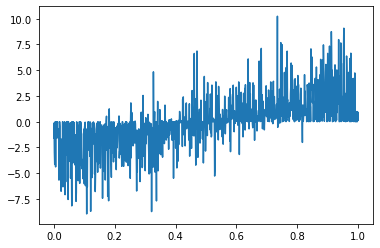

In [31]:
betas = t.linspace(0.0, 1.0, 1000)
obs = model(x_t, t.tensor(0.6))
grads = []
for beta in betas:
    beta.requires_grad_()
    x_tt = model_approx(x_t, beta)
    dist = calc_distance(x_t, x_tt, obs)
    gradient = t.autograd.grad(dist, beta)[0]
    grads.append(gradient.detach().clone())
# %%
plt.plot(betas, grads)

as this is very noisy, we will smooth out the curve using a savgol filter to get an idea of the general trend for the gradient:

In [34]:
def savgol_filter(y, window_size, order, deriv=0, rate=1):
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order + 1)
    half_window = (window_size - 1) // 2
    # precompute coefficients
    b = np.mat(
        [[k**i for i in order_range] for k in range(-half_window, half_window + 1)]
    )
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs(y[1 : half_window + 1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window - 1 : -1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode="valid")

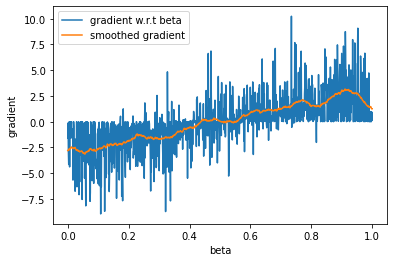

In [35]:
grad_list = np.array([tnsor.numpy() for tnsor in grads])

plt.plot(betas, grads, label="gradient w.r.t beta")
smoothed = savgol_filter(grad_list, 101, 3)
plt.plot(betas, smoothed, label="smoothed gradient")
plt.xlabel("beta")
plt.ylabel("gradient")
plt.legend()
plt.show()

## 4. Defining an update function for the model 

In [37]:
def update(
    beta: t.Tensor, x_t: t.Tensor, x_tt: t.Tensor, learning_rate: float
) -> t.Tensor:
    beta.requires_grad_()
    x_tt = model_approx(x_t, beta)
    dist = calc_distance(x_t, x_tt, test2)
    gradient = t.autograd.grad(dist, beta)[0]
    return beta - learning_rate * gradient

showcasing the update function for a simple example:

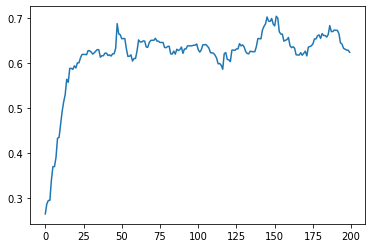

In [40]:
beta = t.tensor(0.2)
obs = model(x_t, t.tensor(0.6))
betas = []
for i in range(200):
    beta = update(beta, x_t, obs, 0.01)
    betas.append(beta.detach())

plt.plot(np.arange(len(betas)), t.tensor(betas))